# Выбор локации для скважины

Имеются данные по пробам нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Нужно решить, где бурить новую скважину. Для этого необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Анализировать возможную прибыль и риски техникой мы будем техникой *Bootstrap.* 

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

### Импорт библиотек и модулей

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import scale

from sklearn.metrics import mean_squared_error

### Загрузка данных

Прочитает исходные данные и сохраним их в трех датасетах.

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Последовательно посмотрим на данные в каждом их них.

In [3]:
data_0.head(10)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [4]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_1.head(10)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [7]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_2.head(10)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [8]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В каждом из представленных датасетов содержатся одинаковые столбцы:
- `id` — уникальный идентификатор скважины, 6 случайных символов;
- `f0`, `f1`, `f2` — три значимых признака, судя по значениям, эти данные уж нормализованы;
- `product` — объем запасов в скважине, измеренный в тыс. баррелей. Целевой признак, т.к. от в зависимости от объема запасов в скважине зависит суммарный доход от нее.

В датасетах нет пропусков.

На первый взгляд, может показаться, что разброс значений в регионах отличается — применим метод `describe`, чтобы проверить это.

In [9]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [10]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [11]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Видно, что хотя признаки масштабированы, они не нормализированы — дисперсия отличается от 1. Кроме того, заметим, как сильно отличаются значения признаков в разных регионах — максимальное значение признака `f1` в первом регионе — `2.36`, а во втором — `29.4`. Примерно также отличаются максимальные значения других признаков по регионам.

### Проверка на явные дубликаты

Перед тем, как продолжить исследование, проверим датасеты на явные дубликаты.

In [12]:
data_0.duplicated().sum()

0

In [13]:
data_1.duplicated().sum()

0

In [14]:
data_2.duplicated().sum()

0

Явных дубликатов не обнаружено.

### Анализ влияния признаков

Проверим наличие линейной зависимости между признаками и целевым признаком в каждом из датасетов.

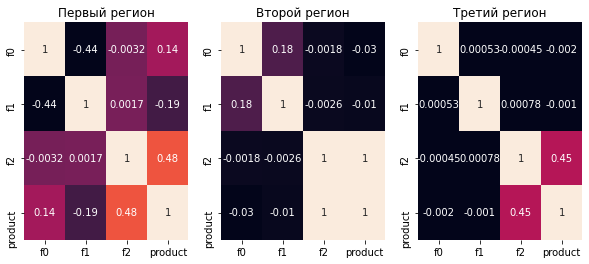

In [15]:
fig = plt.figure(figsize=(10,4))
ax_1 = fig.add_subplot(1,3,1)
ax_2 = fig.add_subplot(1,3,2)
ax_3 = fig.add_subplot(1,3,3)

sns.heatmap(data_0.corr(),
            annot = True,
            cbar=False,
            ax = ax_1)
ax_1.set_title('Первый регион')

sns.heatmap(data_1.corr(),
            annot = True,
            cbar=False,
            ax = ax_2)
ax_2.set_title('Второй регион')

sns.heatmap(data_2.corr(),
            annot = True,
            cbar=False,
            ax = ax_3)
ax_3.set_title('Третий регион')

plt.show()

По признакам `f0` и `f1` линейной зависимости на объем запасов в скважине не наблюдается, а вот признак `f2` оказывает прямое влияние на этот показатель. Более того, во втором регионе между признаком `f2` и объемом запасов в скважине наблюдается **абсолютная** зависимость.

Посмотрим на график по выборке из первых 100 скважин.

<AxesSubplot:xlabel='id', ylabel='product'>

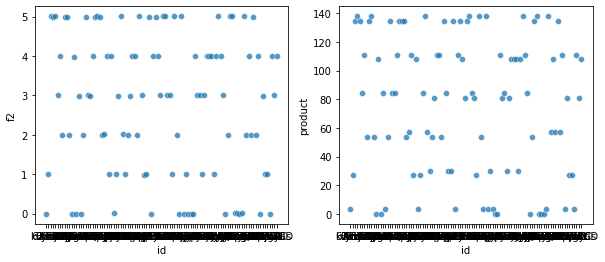

In [16]:
fig = plt.figure(figsize=(10,4))
ax_1 = fig.add_subplot(1,2,1)
ax_2 = fig.add_subplot(1,2,2)
sns.scatterplot(data=data_1.head(100), x="id", y="f2",alpha=0.75, ax=ax_1)
sns.scatterplot(data=data_1.head(100), x="id", y="product",alpha=0.75, ax=ax_2)

Рисунки графиков не идентичны, но почти полностью повторяют друг друга. Это следует учесть при обучение модели для второго региона и дальнейшем анализе.

### Удаление неинформативных столбоцов

В столбцах `id` содержатся уникальные идентификаторы скважин. Однако, т.к. мы можем понять о какой скважине идет речь по индексу объекта, этот столбец является излишним — поэтому его можно удалить из всех датасетов.

In [17]:
data_0 = data_0.drop('id', axis=1)                                                  # удаляем неинформативный id скважины
data_1 = data_1.drop('id', axis=1)
data_2 = data_2.drop('id', axis=1)

## Обучение и проверка модели

### Создание функции для моделей

Т. к. для всех регионов мы будет использовать модель линейной регрессии `LinearRegression`, напишем общую функцию, которая будет делить выборку на обучающую и валидационную, обучать модель, сохранять предсказания модели на валидационной выборке, возвращать средний запас сырья в регионе и RMSE модели.

In [18]:
models = [] #список для сохранения моделей

In [19]:
def get_model(data):
    
    target = data['product']                                                        # целовой признак
    features = data.drop('product', axis=1)                                         # признаки 
    
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=2258)
    
    model = LinearRegression()                                                      # создаем объект модели 
    model.fit(features_train, target_train)                                         # обучаем модель
    predictions_valid = model.predict(features_valid)                               # сохраняем предсказания на валидационной
                                                                                    # выборке
    
    rmse = (mean_squared_error(target_valid,predictions_valid))**0.5                # сохраняем RMSE модели
    mean_product = sum(predictions_valid)/len(predictions_valid)                    # и среднее предсказзаное количество нефти
                                                                                    # в скважинах
    
    models.append(model)
    
    return predictions_valid, mean_product, rmse
    
    
    

Ниже определим вторую функцию `get_model_scale` — она полностью повторяет первую, за исключением того, что признаки будут нормализованы с примением объект `scale`.

In [20]:
def get_model_scale(data):
                          
    target = data['product']                                                        # целовой признак
    features = data.drop('product', axis=1)                                         # признаки 
    features_train, features_valid, target_train, target_valid = train_test_split(features,
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=2258)
    
    features_train = scale(features_train)
    features_valid = scale(features_valid)
    model = LinearRegression()                                                      # создаем объек модели 
    model.fit(features_train, target_train)                                         # обучаем модель
    predictions_valid = model.predict(features_valid)                               # сохраняем предсказания на валидационной
                                                                                    # выборке
    
    rmse = (mean_squared_error(target_valid,predictions_valid))**0.5                # сохраняем RMSE модели
    mean_product = sum(predictions_valid)/len(predictions_valid)                    # и среднее предсказзаное количество нефти
                                                                                    # в скважинах
    
    
    print('Квадратный корень из средней квадратичной ошибки модели (RMSE):', rmse,'\n'
          'Средний запас предсказанного сырья в скважинах в регионе:', mean_product)

### Обучение моделей 

После написания общей функции последовательно применим ее к каждому из регионов и сравним целевую метрику RMSE.

In [21]:
predictions_0, mean_product_0, rmse_0 = get_model(data_0)

print('Квадратный корень из средней квадратичной ошибки модели (RMSE):', rmse_0,'\n'
      'Средний запас предсказанного сырья в скважинах в регионе:', mean_product_0)

Квадратный корень из средней квадратичной ошибки модели (RMSE): 37.82457764774753 
Средний запас предсказанного сырья в скважинах в регионе: 92.31740894644025


In [22]:
predictions_1, mean_product_1, rmse_1 = get_model(data_1)

print('Квадратный корень из средней квадратичной ошибки модели (RMSE):', rmse_1,'\n'
      'Средний запас предсказанного сырья в скважинах в регионе:', mean_product_1)

Квадратный корень из средней квадратичной ошибки модели (RMSE): 0.891742712895835 
Средний запас предсказанного сырья в скважинах в регионе: 68.60475751723025


In [23]:
predictions_2, mean_product_2, rmse_2 = get_model(data_2)

print('Квадратный корень из средней квадратичной ошибки модели (RMSE):', rmse_2,'\n'
      'Средний запас предсказанного сырья в скважинах в регионе:', mean_product_2)

Квадратный корень из средней квадратичной ошибки модели (RMSE): 40.018443694341805 
Средний запас предсказанного сырья в скважинах в регионе: 94.8042354537288


Средний объем предсказаного сырья во втором регионе ниже примерно на 28-30%, что примерно соответсвует всей совокупности данных (среднее значение запасов в первом регионе 92 тыс баррелей, во втором 68 тыс баррелей, в третьем — 95 тыс. баррелей. Однако, модель точно выявила закономерность между объемом запасов во втором регионе и признаком `f1`, за счет чего модель почти не ошибается — условно, ошибка прогноза менее 1 тыс баррелей на скважину. В первом и третьем регионе модель может ошибиться с прогнозом на 50% объема запаса в скважине — а это несет существенные риски.

Повторим алгоритм для моделей с нормализацией признаков.

In [24]:
get_model_scale(data_0)

Квадратный корень из средней квадратичной ошибки модели (RMSE): 37.82461557541932 
Средний запас предсказанного сырья в скважинах в регионе: 92.49960127967324


In [25]:
get_model_scale(data_1)

Квадратный корень из средней квадратичной ошибки модели (RMSE): 0.9352694692596457 
Средний запас предсказанного сырья в скважинах в регионе: 68.89437262576074


In [26]:
get_model_scale(data_2)

Квадратный корень из средней квадратичной ошибки модели (RMSE): 40.01729430552683 
Средний запас предсказанного сырья в скважинах в регионе: 94.94670472031223


Нормализация не дала существенных изменения — несмотря на отсутствие нормализации признаков, их масштаб не отличается сильно и не несет ошибки прогноза.

## Подготовка к расчёту прибыли

### Определение констант

Перед тем перейти к рассчету прибыли и рисков, сохраним основные показатели в соответсвующих переменных. Это позволит при изменении конъюктуры рынка только заменить необходимые значения здесь. Также рассчитаем необходимый объем сырья для безубыточности проекта при текущей конъюктуре.

Бюджет на разработку скважин 10 000 000 000.00 млрд рублей. Он включает в себя разведку 500 скважин и бурение 200 лучших из них.

In [27]:
BUDGET = 10000000000 # бюджет

При нынешних ценах баррель приносит 450 рублей дохода:

In [28]:
BARREL_PROFIT = 450 

Т. к. в скважинах запас нефти указан в тысачах баррелей, прибыль с единицы продукта (целевой признак `product`) будет в 1000 раз больше прибыли с одного барреля:

In [29]:
PRODUCT_PROFIT = BARREL_PROFIT * 1000

Учитывая, что по плану разработано будет 200 скважин, продукт с них должен дать прибыль, которая покроет бюджет.

In [30]:
MEAN_PRODUCT_WITHOUT_LOSSES = (BUDGET / PRODUCT_PROFIT) / 200

In [31]:
MEAN_PRODUCT_WITHOUT_LOSSES

111.11111111111111

При текущей конъюктуре рынка средний запас нефти на 200 лучших скважинах должен быть не менее 111 тысяч баррелей, чтобы мы могли выйти на безубыточность. Это сильно выше чем текущие средние значения по регионам — взять случайные скважины не получится, мы должны точно знать где высокий запас нефти.


### Определение функции прибыли

Т.к. функция прибыли не зависит от региона, определим ее перед тем как перейти к построению прогнозов по выручке, прибыли и убыткам.

In [32]:
def profit(real_product, predicted_product, developed_wells):
    
    top_predicted_product = pd.Series(predicted_product).sort_values(ascending=False).head(developed_wells)
    
    selected_wells_product = real_product[top_predicted_product.index]
    
    total_product = 0
    
    for i in selected_wells_product:
        
        total_product += i       
      
    profit = total_product *  PRODUCT_PROFIT - BUDGET
    
    return profit


Перед тем, как перейти к рассчету прибыли с ограничениями (разведка 500 скважин), проверим работу функции в "идеальных" условиях — когда мы смогли разведать все скважины в регионе и выбрать лучшее 200, основываясь на предсказаниях модели. А также сравним с идеальной выборкой - если бы нам удалось определить 200 самых "топовых" скважин.

Сначала проверим в **первом регионе**.

In [33]:
model = models[0]                                         # выбираем из списка моделей модель обученную на первом регионе

target = data_0['product']                                # определяем целевой признак                  
features = data_0.drop('product', axis=1)                 # и признаки для предсказания

In [34]:
predictions = model.predict(features)                     # предсказания модели

In [35]:
profit(target, predictions, 200)                          # прибыль из 200 скважин, с лучшими предсказаниями 
                                                          # при разведке во всех 100 000 скважин

3488027732.251112

In [36]:
sum((data_0.sort_values(by='product', ascending=False).head(200)['product']))*PRODUCT_PROFIT - BUDGET

6635036568.08242

Предсказания модели позволяют нам получить прибыль почти в 3,5 млрд рублей — а в идеальном мире мы бы могли получить 6,6 млрд прибыли — и иметь рентабельность бизнеса в 66%.

**Во втором регионе**:

In [37]:
model = models[1] # выбираем из списка моделей модель обученную на втором регионе

target = data_1['product']                                      # определяем целевой признак                  
features = data_1.drop('product', axis=1)                       # и признаки для предсказания

In [38]:
predictions = model.predict(features)  

In [39]:
profit(target, predictions, 200)

2415086696.681551

In [40]:
sum((data_1.sort_values(by='product', ascending=False).head(200)['product']))*PRODUCT_PROFIT - BUDGET

2415086696.681551

Более низкий средний запас нефти в скважинах во втором регионе сказывается как на максимально достижимой прибыли (2,4 млрд рублей), так и на прибыли, которую мы можем получить. Но главное **предсказания модели совпадают с максимальной прибылью** т.к. запас нефти в скважинах коррелирует с параметром `f2`.

**Для третьего региона**:

In [41]:
model = models[2] # выбираем из списка моделей модель обученную на третьем регионе

target = data_2['product']                                      # определяем целевой признак                  
features = data_2.drop('product', axis=1)                       # и признаки для предсказания

In [42]:
predictions = model.predict(features)  

In [43]:
profit(target, predictions, 200)

2555578577.5059586

In [44]:
sum((data_2.sort_values(by='product', ascending=False).head(200)['product']))*PRODUCT_PROFIT - BUDGET

7059632928.358988

Третий регион представляет собой некоторый усредненный вариант — потенциальная прибыль чуть больше, чем в первом регионе, но предсказывать запасы сложнее — даже при разведке всех скважин модель смогла гарантировать прибыль только в 2,5 млрд . 

## Расчёт прибыли и рисков 

Настало время посчитать потенциальные риски и прибыль, которые несет с собой использование моделей. Для этого создадим искуссвтенные выборки по 500 скважин, которые могли бы разведовать в регионе, и посчитаем прибыль при условии разработки 200 из них, которые модель считает потенциально лучшими.

Для воспроизводимости случайных значений, определим объект `RandomState` перед тем как продолжить.

In [45]:
state = np.random.RandomState(2258)

### Расчет прибыли и рисков для первого региона

Построим предсказания для первого региона:

In [46]:
model = models[0]   # выбираем из списка моделей модель обученную на первом регионе

In [47]:
profits_0 = []      # определим список, в который сохраним прибыли каждой из выборок

In [48]:
target = pd.Series(data_0['product'])                                      # определяем целевой признак                  
features = data_0.drop('product', axis=1)                                  # и признаки для предсказания
predictions = pd.Series(model.predict(features))


In [50]:
for _ in range(1000):
    
    target_subsample = target.sample(frac=0.005, replace=True, random_state = state) # frac = 500 / 100000
    
    predicted_products_subsample = predictions[target_subsample.index]               # выбираем прогнозные значения за счет
                                                                                     # индексов
    
    profits_0.append(profit(target,predicted_products_subsample,200))      # добавляем в список значение прибыли
                                                                                     # для текущей выборки
    
  


In [51]:
np.mean(profits_0)                            # среднее значение прибыли в регионе

424090668.3896487

Средняя прибыль в регионе - 424 млн. При затратах в 10 млрд получаем рентабельность в :

In [52]:
Out[51] / BUDGET

0.042409066838964865

**4,2%**. Не очень много — банковский вклад дает больше. Посмотрим на вероятность понести убытки.

In [53]:
profits_0 = pd.Series(profits_0)              # изменяем тип со списка на Series

In [54]:
len(profits_0[profits_0 < 0])/len(profits_0)

0.056

На 1000 случайных выбор из первого региона мы ушли в минус в 5,6 % случаев. Это больше установленого ограничениями 2,5%. Однако, сейчас в результатах сохранены крайние значения, которые могут искажать результат как выбросы. Посмотрим на  доверительный интервал в 95% — то есть, значения прибыли, которые мы получим в 95% случаев.

In [55]:
lower = profits_0.quantile(q=0.025)  # отбросим 2,5 % снизу
upper = profits_0.quantile(q=0.975)  # и 2,5 % сверху

print(lower)
print(upper)

-80836368.50123505
922482542.3969227


Нижняя граница интервала имеет отрицательное значение — а значит, мы все еще очень рискуем понести убытки, начав разработку в регионе. Посмотрим, может во втором регионе картина будет лучше.

### Расчет прибыли и рисков для второго региона

In [56]:
model = models[1]   # выбираем из списка моделей модель обученную на втором регионе

In [57]:
profits_1 = []      # определим список, в который сохраним прибыли каждой из выборок из второго региона

In [58]:
target = pd.Series(data_1['product'])                                      # определяем целевой признак                  
features = data_1.drop('product', axis=1)                                  # и признаки для предсказания
predictions = pd.Series(model.predict(features))

In [59]:
for _ in range(1000):
    
    target_subsample = target.sample(frac=0.005, replace=True, random_state = state) # frac = 500 / 100000
    
    predicted_products_subsample = predictions[target_subsample.index]               # выбираем прогнозные значения за счет
                                                                                     # индексов
    
    profits_1.append(profit(target,predicted_products_subsample,200))      # добавляем в список значение прибыли
                                                                                     # для текущей выборки

In [60]:
np.mean(profits_1)     

446494010.40737927

Средняя прибыль не сильно выше, чем в первом рассматриваемом регоине.

In [61]:
profits_1 = pd.Series(profits_1)
len(profits_1[profits_1 < 0])/len(profits_1)

0.013

А вот отрицательных значений почти нет — модель точно предсказывает запасы в скважинах — вероятность понести убыток чуть больше 1%.

In [62]:
lower = profits_1.quantile(q=0.025)  # отбросим 2,5 % снизу
upper = profits_1.quantile(q=0.975)  # и 2,5 % сверху

print(lower)
print(upper)

59552580.373029046
848052090.2327411


В регионе почти гарантированно выходим в прибыль. Вот только верняя граница доверительного интервала ниже - сильно заработать тут не получится.

### Расчет прибыли и рисков для третьего региона

In [63]:
model = models[2]   # выбираем из списка моделей модель обученную на третьем регионе

In [64]:
profits_2 = []      # определим список, в который сохраним прибыли каждой из выборок из третьего региона

In [65]:
target = pd.Series(data_2['product'])                                      # определяем целевой признак                  
features = data_2.drop('product', axis=1)                                  # и признаки для предсказания
predictions = pd.Series(model.predict(features))

In [66]:
for _ in range(1000):
    
    target_subsample = target.sample(frac=0.005, replace=True, random_state = state) # frac = 500 / 100000
    
    predicted_products_subsample = predictions[target_subsample.index]               # выбираем прогнозные значения за счет
                                                                                     # индексов
    
    profits_2.append(profit(target,predicted_products_subsample,200))      # добавляем в список значение прибыли
                                                                                     # для текущей выборки

In [67]:
np.mean(profits_2)  

387595902.1859713

In [68]:
profits_2 = pd.Series(profits_2)
len(profits_2[profits_2 < 0])/len(profits_2)

0.082

Что-то работа в третьем регионе не воодушевляет — в 8,2 % случаев мы понесли убытки, а средняя прибыль даже ниже, чем в первом регионе. Возможно, это регион для тех кто любит рисковать? Посмотрим на верхнюю границу доверительного интервала в 95%.



In [69]:
lower = profits_2.quantile(q=0.025)  # отбросим 2,5 % снизу
upper = profits_2.quantile(q=0.975)  # и 2,5 % сверху

print(lower)
print(upper)

-174179729.7896341
941130513.5815474


Верхняя граница лишь слегка выше, чем в первом регионе, а нижняя больше по модулю — т е работа в регионе грозит большими убытками.

### Выбор региона

Единственным регионом, который отвечает заявленным требованием, является второй регион. Модель способна точно предсказать запас в скважинах, и риск понести убыток здесь значительно меньше 2,5% . Кроме того, точный прогноз гарантирует в среднем более выскоую прибыль.

95%-доверительный интервал в регоионе имеет границы от 83 826 065 до 982 204 690 — то есть, компания почти гарантирует себе минимальную прибыль.

In [70]:
positive = profits_1[profits_1 > 0]
negative = profits_1[profits_1 < 0]

<AxesSubplot:>

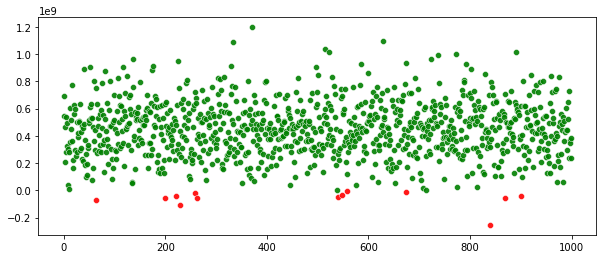

In [71]:
fig = plt.figure(figsize=(10,4))

sns.scatterplot(data=profits_1, x=positive.index, y=positive,alpha=0.9, color='green')
sns.scatterplot(data=profits_1, x=negative.index, y=negative,alpha=0.9, color='red')



На диаграмме рассеяния видно, что при 1000 выборок по 500 скважин в регионе мы почти не уходили в ноль — точки ниже нуля можно пересчитать по пальцам.